# Black-Litterman allocation

<!-- The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio. -->

Black-Litterman 방법은 자산 수익에 대한 견해와 이러한 견해의 불확실성을 포트폴리오로 전환하는 매우 강력한 방법입니다.

<!-- For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein. -->

이론에 대한 설명은 [문서 페이지](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html)와 링크를 참조하십시오

<!-- In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimisation -->

이 레시피에서는 다음을 다룹니다.

- Black-Litterman 메서드에 대한 데이터 다운로드
- 시장 균형을 기반으로 사전 수익 벡터 구성
- 불확실성 매트릭스를 구성하는 두 가지 방법
- Black-Litterman과 평균 분산 최적화 결합

## Downloading data

<!-- In addition to price data, constructing a market prior requires market-caps.  -->

가격 데이터 외에도 시장을 사전에 구성하려면 시가총액<sup>market-caps</sup>이 필요합니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [3]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2020-11-16,3131.060059,27.580000,379.790009,144.669998,384.820007,53.849998,216.729996,216.662766,3.26,97.779999
2020-11-17,3135.659912,27.549999,381.920013,144.500000,384.470001,53.680000,216.009995,213.900009,3.27,98.599998
2020-11-18,3105.459961,26.980000,382.230011,143.899994,382.459991,52.610001,215.520004,211.080002,3.08,97.910004
2020-11-19,3117.020020,26.980000,383.540009,141.720001,385.040009,53.130001,215.110001,212.419998,3.25,97.760002
2020-11-20,3099.399902,26.809999,381.119995,141.070007,389.559998,52.669998,214.089996,210.389999,3.31,97.010002


In [4]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    26.079659
1993-02-01    26.265144
1993-02-02    26.320782
1993-02-03    26.599014
1993-02-04    26.710312
Name: Adj Close, dtype: float64

In [9]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    print(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

MSFT
AMZN
NAT
BAC
DPZ
DIS
KO
MCD
COST
SBUX


{'MSFT': 1590653616128,
 'AMZN': 1555127074816,
 'NAT': 500488512,
 'BAC': 231927676928,
 'DPZ': 15348625408,
 'DIS': 254921965568,
 'KO': 226345631744,
 'MCD': 159520800768,
 'COST': 168160821248,
 'SBUX': 113860632576}

## Constructing the prior 사전 구축

In [10]:
import pypfopt
pypfopt.__version__

'1.2.7'

In [11]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.567252332022072

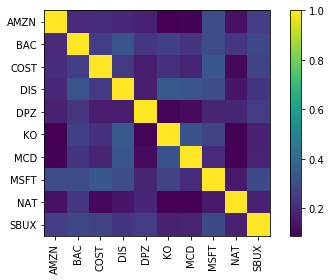

In [12]:
plotting.plot_covariance(S, plot_correlation=True);

In [13]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.187689
BAC     0.100618
COST    0.074340
DIS     0.093951
DPZ     0.047167
KO      0.062546
MCD     0.067277
MSFT    0.127000
NAT     0.051210
SBUX    0.078970
dtype: float64

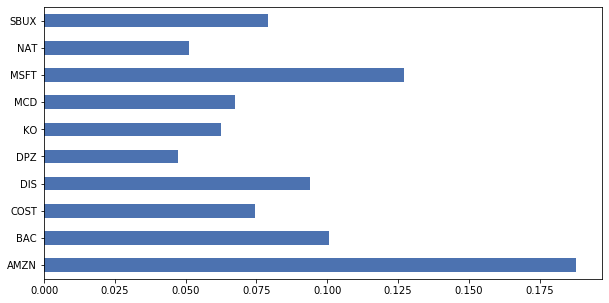

In [14]:
market_prior.plot.barh(figsize=(10,5));

## Views

<!-- In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.  -->

BL 메서드에서 뷰는 행렬 P(픽킹 행렬)와 벡터 Q를 통해 지정됩니다. Q에는 각 뷰의 크기가 포함되고 P는 뷰가 속한 자산에 매핑됩니다.


<!-- If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary. -->

**절대적 뷰**<sup>absolute views</sup>(예 : 각 자산에 대한 예상 수익)를 제공하는 경우 P와 Q에 대해 걱정할 필요가 없으며 뷰를 사전으로 전달할 수 있습니다.



In [15]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

<!-- Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views). -->

Black-Litterman은 또한 예를 들어 자산 A가 자산 B를 10% 능가 할 것이라고 생각하는 등의 상대적인 뷰를 허용합니다. 이를 통합하려면 P와 Q를 직접 만들어야합니다. 이에 대한 설명은 [문서](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views)에 나와 있습니다.

## View confidences

<!-- In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences. -->

이 섹션에서는 불확실성<sup>uncertainty</sup> 매트릭스를 구성 할 수 있는 두 가지 방법을 제공합니다. 첫 번째는 Idzorek의 메서드로 알려져 있습니다. 벡터/백분율 신뢰도 리스트를 지정할 수 있습니다.

In [16]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [17]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

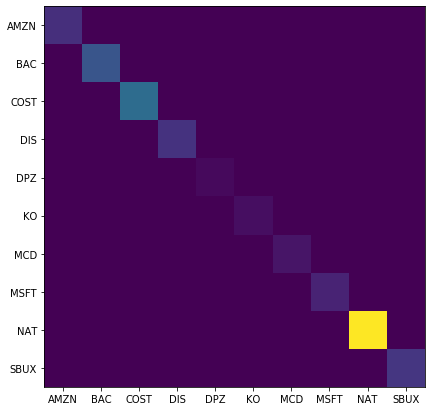

In [18]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [19]:
np.diag(bl.omega)

array([0.00459877, 0.00900387, 0.01214375, 0.00497373, 0.00080721,
       0.00125653, 0.00196619, 0.00345157, 0.03433906, 0.00538514])

<!-- Note how NAT, which we gave the lowest confidence, also has the highest uncertainty. -->

가장 낮은 신뢰도를 제공 한 NAT가 또한 가장 높은 불확실성을 가지고 있음을 주목하십시오.

<!-- Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences -->

신뢰도를 입력하는 대신 1개의 표준 편차 신뢰 구간, 즉 시간의 68%가 실제 수익을 포함 할 것으로 생각되는 경계를 지정하여 불확실성 행렬을 직접 계산할 수 있습니다. 이것은 임의의 백분율 신뢰도를 갖는 것보다 쉬울 수 있습니다.

In [20]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [21]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates 사후 추정치

<!-- Given the inputs, we can compute a posterior estimate of returns -->

입력 값이 주어지면 수익의 사후 추정치를 계산할 수 있습니다.

In [22]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [23]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.163564
BAC     0.134765
COST    0.060686
DIS     0.073348
DPZ     0.101779
KO      0.004721
MCD     0.108347
MSFT    0.102125
NAT     0.060862
SBUX    0.082837
dtype: float64

<!-- We can visualise how this compares to the prior and our views: -->

이것이 이전 및 우리의 견해와 어떻게 비교되는지 시각화 할 수 있습니다.

In [24]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.187689,0.163564,0.10
BAC,0.100618,0.134765,0.30
COST,0.074340,0.060686,0.05
DIS,0.093951,0.073348,0.05
DPZ,0.047167,0.101779,0.20
KO,0.062546,0.004721,-0.05
MCD,0.067277,0.108347,0.15
MSFT,0.127000,0.102125,0.10
NAT,0.051210,0.060862,0.50
SBUX,0.078970,0.082837,0.10


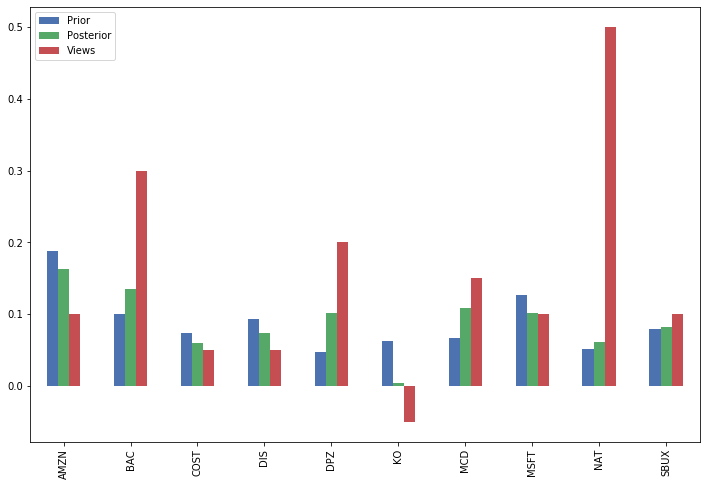

In [25]:
rets_df.plot.bar(figsize=(12,8));

<!-- Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence. -->

사후는 종종 사전과 뷰 사이에 있습니다. 이는 BL 방법이 기본적으로 사전 및 뷰의 베이지안 가중 평균이라는 사실을 뒷받침합니다. 여기서 가중치는 신뢰도에 의해 결정됩니다.

<!-- A similar but less intuitive procedure can be used to produce the posterior covariance estimate: -->

유사하지만 덜 직관적인 절차를 사용하여 사후 공분산 추정치를 생성 할 수 있습니다.

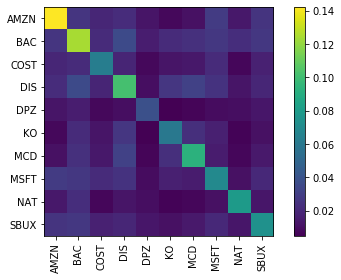

In [26]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

<!-- Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimisers discussed in previous recipes. -->

이제 Black-Litterman 사후 추정치를 구성 했으므로 이전 레시피에서 논의한 옵티 마이저를 계속 사용할 수 있습니다.

In [27]:
from pypfopt import EfficientFrontier, objective_functions

In [28]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/hosung/anaconda3/envs/quantpython/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


OrderedDict([('AMZN', 0.20645),
             ('BAC', 0.16067),
             ('COST', 0.0521),
             ('DIS', 0.06499),
             ('DPZ', 0.12869),
             ('KO', 0.0),
             ('MCD', 0.12965),
             ('MSFT', 0.11719),
             ('NAT', 0.05489),
             ('SBUX', 0.08537)])

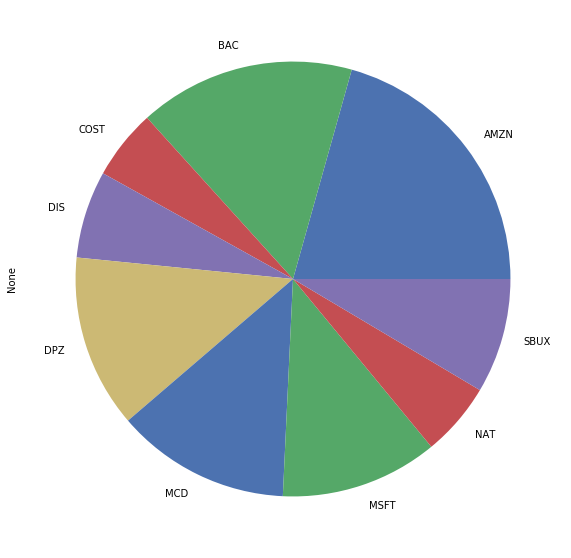

In [29]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [30]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $249.47


{'AMZN': 1,
 'BAC': 120,
 'COST': 3,
 'DIS': 10,
 'DPZ': 7,
 'MCD': 13,
 'MSFT': 12,
 'NAT': 332,
 'SBUX': 18}